In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import os
import getpass
import gc
from pathlib import Path

import itertools

import xgboost as xgb
from lightgbm import LGBMRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

from tqdm.notebook import tqdm
import warnings
#warnings.filterwarnings('ignore')

In [2]:
def mean_enconding2(train, test, column, alpha=5):
    
    #encode on train
    kf = KFold(n_splits=5, shuffle=False)
    globalmean = train[column].mean()
    
    for train_ix, test_ix in kf.split(train):
        tr, te = train.iloc[train_ix], train.iloc[test_ix]
        
        #smoothing
        column_enc = (tr.groupby(column)['item_cnt_month'].mean()
                        * tr.groupby(column)['item_cnt_month'].count()
                        + globalmean * alpha) / (tr.groupby(column)['item_cnt_month'].count() + alpha)
        #column_enc = tr.groupby(column)['item_cnt_month'].mean()
        
        train.loc[test_ix, column+'_enc'] = train.loc[test_ix, column].map(column_enc)

    #fill nan with global mean
    train[column+'_enc'] = train[column+'_enc'].fillna(globalmean)    
    
    #######################################################################################################
    
    #encode on test
    column_enc = (train.groupby(column)['item_cnt_month'].mean()
                        * train.groupby(column)['item_cnt_month'].count()
                        + globalmean * alpha) / (train.groupby(column)['item_cnt_month'].count() + alpha)
    
    test[column+'_enc'] = test[column].map(column_enc)
    test[column+'_enc'] = test[column+'_enc'].fillna(globalmean)

    return train, test

#with such encoding got better results
def cv_mean_enc(sample, column, kf, globalmean, alpha):
    
    for train_ix, test_ix in kf.split(sample):
        train, test = sample.iloc[train_ix], sample.iloc[test_ix]
        
        #smoothing
        column_enc = (train.groupby(column)['item_cnt_month'].mean()
                        * train.groupby(column)['item_cnt_month'].count()
                        + globalmean * alpha) / (train.groupby(column)['item_cnt_month'].count() + alpha)
        #column_enc = train.groupby(column)['item_cnt_month'].mean()


        
        sample.loc[test_ix, column+'_enc'] = sample.loc[test_ix, column].map(column_enc)

    #fill nan with global mean
    sample[column+'_enc'].fillna(globalmean, inplace=True) 
    
    return sample
    
def mean_enconding(sample, column, alpha=5):

    kf = KFold(n_splits=5, shuffle=False)
    
    
    #globalmean_part = sample_part[column].mean()
    globalmean = sample[column].mean()
    
    #sample_part = cv_mean_enc(sample_part, column, kf, globalmean_part, alpha)
    sample = cv_mean_enc(sample, column, kf, globalmean, alpha)

    return sample

In [3]:
DATA_DIR = Path('/data', getpass.getuser(), 'kaggle', 'future_sales') #path to data files

sales = pd.read_csv(DATA_DIR / 'sales_train.csv')
items = pd.read_csv(DATA_DIR / 'items.csv')
item_categories = pd.read_csv(DATA_DIR / 'item_categories.csv')
shops = pd.read_csv(DATA_DIR /'shops.csv')

test = pd.read_csv(DATA_DIR / 'test.csv').set_index('ID')

**Little preporcessing**

In [4]:
def shop_id_change(sample):
    sample.loc[sample['shop_id']==57, 'shop_id'] = 0
    sample.loc[sample['shop_id']==58, 'shop_id'] = 1
    sample.loc[sample['shop_id']==11, 'shop_id'] = 10
    
    return sample

In [5]:
sales = sales[(sales['item_cnt_day'] <= 900) & (sales['item_price'] <= 60000) & ((sales['item_price'] >= 0))]

In [6]:
#change shop_id
sales = shop_id_change(sales)
shops = shop_id_change(shops)
test = shop_id_change(test)

In [7]:
#create feature - city
shops['shop_city'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.strip()
shops['shop_city'] = shops['shop_city'].apply(lambda x: x.split()[0])
shops['shop_city'] = LabelEncoder().fit_transform(shops['shop_city'])

In [8]:
#create feature - section of products
item_categories['item_section_name'] = item_categories['item_category_name'] \
                                        .apply(lambda x: x.lower().split('-')[0].split()[0].strip())
item_categories['item_section_name'] = LabelEncoder().fit_transform(item_categories['item_section_name'])


Since we need to predict monthly, so aggregate data

In [9]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = []

for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(itertools.product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)


# Aggregations
sales['item_cnt_day'] = sales['item_cnt_day'].clip(0,20) #seems it's better to clip here
train = sales.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False) \
            .agg({'item_cnt_day':'sum', 'item_price':'mean'})
train = train.rename(columns = {'item_cnt_day' : 'item_cnt_month'})
train['item_cnt_month'] = train['item_cnt_month'].clip(0,20) #one more clip

#merge aggregated sales and grid
train = pd.merge(grid, train, how='left',on=index_cols)
train['item_cnt_month'] = train['item_cnt_month'].fillna(0)

In [10]:
train = train.drop(['item_price'], axis=1)
print(train.shape)
train.head(2)

(10913804, 4)


,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0


In [11]:
#add some features to train
train = train.merge(items[['item_id', 'item_category_id']], on='item_id')
train = train.merge(item_categories[['item_category_id', 'item_section_name']], on='item_category_id')
train = train.merge(shops[['shop_city', 'shop_id']], on='shop_id')

train = train.drop_duplicates()
train = train.sort_values(by=['date_block_num']).reset_index(drop=True)
train.head(2)

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,item_section_name,shop_city
0,59,22154,0,1.0,37,7,30
1,16,6197,0,0.0,55,9,10


In [12]:
test['date_block_num']= 34
test['item_cnt_month'] = -1 #since need to predict it
print(test.shape)

(214200, 4)


In [13]:
test = test.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
test = test.merge(item_categories[['item_category_id', 'item_section_name']], on='item_category_id', how='left')
test = test.merge(shops[['shop_city', 'shop_id']], on='shop_id', how='left')
test = test.drop_duplicates().reset_index(drop=True)

In [14]:
test.head(2)

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,item_section_name,shop_city
0,5,5037,34,-1,19,5,3
1,5,5320,34,-1,55,9,3


**Combine data**

In [15]:
#concat all data to create mean encoded features and lag ones
all_data = pd.concat([train, test]).reset_index(drop=True)

In [22]:
# List of columns that we will use to create lags
lag_features = ['item_cnt_month']

shift_range = list(range(1, 13))

for month_shift in tqdm(shift_range):
    train_shift = all_data[index_cols + lag_features].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: f'{x}_lag_{month_shift}' if x in lag_features else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

In [23]:
#one more features since we have predict based on pairs shop_id and item_id
all_data['shop_item'] = (all_data['shop_id'].astype(str) + '0' + all_data['item_id'].astype(str)).astype(int)
#order of month
all_data['month'] = all_data['date_block_num'].apply(lambda x: x % 12)

In [24]:
all_data.head(2)

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,item_section_name,shop_city,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,...,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12,shop_item,month
0,59,22154,0,1.0,37,7,30,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59022154,0
1,16,6197,0,0.0,55,9,10,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1606197,0


**mean encoding 1**

In [16]:
#train_part, val = all_data[all_data['date_block_num'] < 33], all_data[all_data['date_block_num'] == 33]
#train, test = all_data[all_data['date_block_num'] < 34], all_data[all_data['date_block_num'] == 34]
#############################################################################################
all_data_part = all_data[all_data['date_block_num'] < 34]

In [26]:
mean_enc_features = ['item_id', 'shop_id', 'item_category_id', 'item_section_name', 'shop_city', 'shop_item']
#encode for all train data and test
#for col in tqdm(mean_enc_features):
#    train, test = mean_enconding(train.copy(), test.copy(), col)

#encode for train_part data and validation
#for col in tqdm(mean_enc_features):
#    train_part, val = mean_enconding(train_part.copy(), val.copy(), col)
#####################################################################################################
for col in tqdm(mean_enc_features):
    all_data = mean_enconding(all_data.copy(), col)

for col in tqdm(mean_enc_features):
    all_data_part = mean_enconding(all_data_part.copy(), col)

In [27]:
#to validate
train_part = all_data_part[all_data_part['date_block_num'] < 33]
val = all_data_part[all_data_part['date_block_num'] == 33]

#to fit on all data
train, test = all_data[all_data['date_block_num'] < 34], all_data[all_data['date_block_num'] == 34]

In [28]:
Xtrain_part, ytrain_part = train_part.drop(['item_cnt_month'] , axis=1), train_part['item_cnt_month']
Xval, yval = val.drop(['item_cnt_month'] , axis=1), val['item_cnt_month']

Xtrain, ytrain = train.drop(['item_cnt_month'] , axis=1), train['item_cnt_month']
Xtest, ytest = test.drop(['item_cnt_month'] , axis=1), test['item_cnt_month']

dtrain_part = xgb.DMatrix(data=Xtrain_part.to_numpy(), label=ytrain_part
                     , feature_names=Xtrain.columns)
dval = xgb.DMatrix(data=Xval.to_numpy(), label=yval
                     , feature_names=Xtrain.columns)

dtrain = xgb.DMatrix(data=Xtrain.to_numpy(), label=ytrain
                     , feature_names=Xtrain.columns)
dtest = xgb.DMatrix(data=Xtest.to_numpy(), label=ytest
                   , feature_names=Xtrain.columns)

**mean encoding 2**

In [29]:
train_part, val = all_data[all_data['date_block_num'] < 33], all_data[all_data['date_block_num'] == 33]
train, test = all_data[all_data['date_block_num'] < 34], all_data[all_data['date_block_num'] == 34]

In [30]:
mean_enc_features = ['item_id', 'shop_id', 'item_category_id', 'item_section_name', 'shop_city', 'shop_item']
#encode for all train data and test
for col in tqdm(mean_enc_features):
    train, test = mean_enconding2(train.copy(), test.copy(), col)

#encode for train_part data and validation
for col in tqdm(mean_enc_features):
    train_part, val = mean_enconding2(train_part.copy(), val.copy(), col)

In [31]:
Xtrain_part, ytrain_part = train_part.drop(['item_cnt_month'] , axis=1), train_part['item_cnt_month']
Xval, yval = val.drop(['item_cnt_month'] , axis=1), val['item_cnt_month']

Xtrain, ytrain = train.drop(['item_cnt_month'] , axis=1), train['item_cnt_month']
Xtest, ytest = test.drop(['item_cnt_month'] , axis=1), test['item_cnt_month']

dtrain_part2 = xgb.DMatrix(data=Xtrain_part.to_numpy(), label=ytrain_part
                     , feature_names=Xtrain.columns)
dval2 = xgb.DMatrix(data=Xval.to_numpy(), label=yval
                     , feature_names=Xtrain.columns)

dtrain2 = xgb.DMatrix(data=Xtrain.to_numpy(), label=ytrain
                     , feature_names=Xtrain.columns)
dtest2 = xgb.DMatrix(data=Xtest.to_numpy(), label=ytest
                   , feature_names=Xtrain.columns)

In [32]:
default_params = {  'objective': 'reg:squarederror'                    
                    , 'subsample': 0.8
                    , 'colsample_bytree': 0.9
                    , 'learning_rate': 0.1
                    , 'tree_method': 'hist'
                    , 'grow_policy': 'lossguide'
                    , 'max_leaves': 63
                    , 'max_depth': 0
                    , 'gamma': 1
                    , 'reg_alpha': 1.2
                    , 'reg_lambda': 1.3
                    , 'min_child_weight': 30
                    , 'max_delta_step': 2
                    , 'n_jobs': 60
                    , 'random_state': 42
                    , 'eval_metric': 'rmse'
                }   

In [33]:
model1_part = xgb.train(default_params, dtrain_part, num_boost_round=1000, early_stopping_rounds=100, verbose_eval=100
           , evals=[(dtrain_part,'train_part'), (dval,'val')])

[0]	train_part-rmse:1.21758	val-rmse:1.14277
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train_part-rmse:0.90413	val-rmse:0.94380
[200]	train_part-rmse:0.87548	val-rmse:0.95656
Stopping. Best iteration:
[134]	train_part-rmse:0.89354	val-rmse:0.94200



In [34]:
model1 = xgb.train(default_params, dtrain, num_boost_round=500, early_stopping_rounds=100, verbose_eval=100
           , evals=[(dtrain,'train')])

[0]	train-rmse:1.21626
Will train until train-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.90627
[200]	train-rmse:0.87786
[300]	train-rmse:0.85982
[400]	train-rmse:0.84615
[499]	train-rmse:0.83393


In [35]:
ans = pd.DataFrame({'item_cnt_month': model1.predict(dtest)})
ans['item_cnt_month'] = ans['item_cnt_month'].clip(0, 20)
ans.insert(0, 'ID', ans.index)
ans.to_csv(DATA_DIR / 'mean_enc1.csv', index=False)
#0.977033

In [36]:
model2_part = xgb.train(default_params, dtrain_part2, num_boost_round=1000, early_stopping_rounds=100, verbose_eval=100
           , evals=[(dtrain_part2,'train_part'), (dval2,'val')])

[0]	train_part-rmse:1.21761	val-rmse:1.14216
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train_part-rmse:0.90500	val-rmse:0.93927
[200]	train_part-rmse:0.87655	val-rmse:0.93528
[300]	train_part-rmse:0.85785	val-rmse:0.93314
[400]	train_part-rmse:0.84223	val-rmse:0.93405
Stopping. Best iteration:
[348]	train_part-rmse:0.85027	val-rmse:0.93219



In [37]:
model2 = xgb.train(default_params, dtrain2, num_boost_round=500, early_stopping_rounds=100, verbose_eval=100
           , evals=[(dtrain2,'train_part')])

[0]	train_part-rmse:1.21597
Will train until train_part-rmse hasn't improved in 100 rounds.
[100]	train_part-rmse:0.90392
[200]	train_part-rmse:0.87673
[300]	train_part-rmse:0.85785
[400]	train_part-rmse:0.84372
[499]	train_part-rmse:0.83215


In [38]:
ans = pd.DataFrame({'item_cnt_month': model2.predict(dtest)})
ans['item_cnt_month'] = ans['item_cnt_month'].clip(0, 20)
ans.insert(0, 'ID', ans.index)
ans.to_csv(DATA_DIR / 'mean_enc2.csv', index=False)
#0.981799

**one more try witn mean encoding 1**

In [139]:
ans = pd.DataFrame({'item_cnt_month': model1.predict(dtest)})
ans['item_cnt_month'] = ans['item_cnt_month'].clip(0, 20)
ans.insert(0, 'ID', ans.index)

In [110]:
test.shape

(214200, 27)

In [140]:
thr = 1
x1, x2 = ans.loc[ans['item_cnt_month'] < thr], ans.loc[ans['item_cnt_month'] >= thr]
x1.shape

(202672, 2)

[29884. 17414. 18188. 18264. 12393. 11449.  9881.  7856.  9019.  7369.]
[0.         0.01999961 0.03999921 0.05999882 0.07999843 0.09999803
 0.11999764 0.13999724 0.15999685 0.17999646]


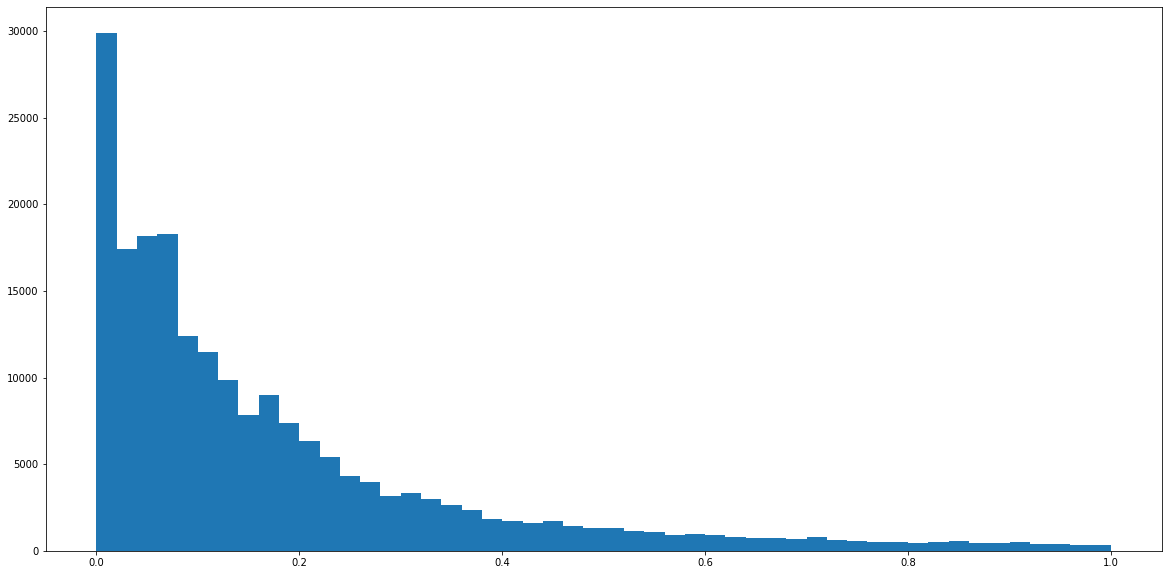

In [141]:
plt.figure(figsize=(20,10))
n, bins, _ = plt.hist(x1['item_cnt_month'], bins=50)
print(n[:10])
print(bins[:10])
plt.show()

[8039. 1813.  734.  341.  174.  110.   72.   46.   63.   21.]
[ 1.0000651  2.2667274  3.5333898  4.800052   6.0667143  7.333377
  8.6000395  9.866701  11.133364  12.400026 ]


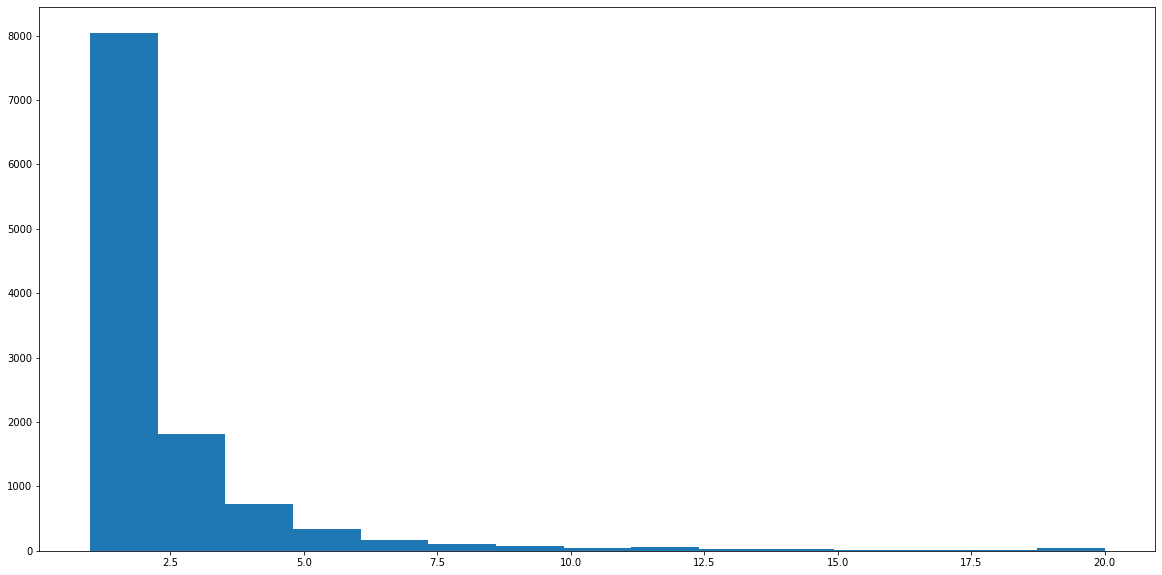

In [142]:
plt.figure(figsize=(20,10))
n, bins, _ = plt.hist(x2['item_cnt_month'], bins=15)
print(n[:10])
print(bins[:10])
plt.show()

In [143]:
ans['item_cnt_month'] = np.where(ans['item_cnt_month'] < 0.02, 0, ans['item_cnt_month'])
ans['item_cnt_month'] = np.where((ans['item_cnt_month'] < 1.1) & (ans['item_cnt_month'] > 0.9), 1, ans['item_cnt_month'])

In [144]:
ans.to_csv(DATA_DIR / 'mean_enc1_1.csv', index=False)
#0.977104 - a bit worse